In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
import seaborn as sns
from matplotlib import rcParams

In [2]:
sns.set_style('whitegrid')
rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = (4, 3)
rcParams['grid.linewidth'] = 0.5
rcParams['grid.linestyle'] = 'dashed'
rcParams['legend.fancybox'] = False
rcParams['mathtext.fontset'] = 'stix'

dpi = 200

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/igor-sadalski/Scaling-up-measurement-noise-scaling-laws/main/collect_mi_results.csv')
df.replace('celltype.l3', 'Cell type MI', inplace=True)
df.replace('protein_counts', 'Protein MI', inplace=True)
df.replace('clone', 'Clonal MI', inplace=True)
df.replace('author_day', 'Temporal MI', inplace=True)
df.replace('ng_idx', 'Spatial MI', inplace=True)
df.replace('RandomProjection', 'Rand. Proj.', inplace=True)

In [4]:
# sc_param_df = pd.read_csv('analysis/final_results/cell_scaling_N0_21733.759_s_0.502_I_inf_2.927_I_0_0.730.csv')
sc_param_df = pd.read_csv('analysis/final_results/cell_scaling_N0_13906.063_s_1.051_I_inf_1.304.csv')
sc_param_df.replace('celltype.l3', 'Cell type MI', inplace=True)
sc_param_df.replace('protein_counts', 'Protein MI', inplace=True)
sc_param_df.replace('clone', 'Clonal MI', inplace=True)
sc_param_df.replace('author_day', 'Temporal MI', inplace=True)
sc_param_df.replace('ng_idx', 'Spatial MI', inplace=True)
sc_param_df.replace('RandomProjection', 'Rand. Proj.', inplace=True)

In [17]:
sc_param_df['min I'] = [df[(df['signal'] == metric) & (df['quality'] == 1) 
                           & (df['algorithm'] == method)]['mi_value'].min() 
                           for metric, method in zip(sc_param_df['metric'].values, sc_param_df['method'].values)]

In [5]:
# sc_param_df['N_90'] = sc_param_df['N0'] * (0.1 *sc_param_df['I_inf'])**(-1/sc_param_df['s'])

In [6]:
pretty_palette = ["#C85158",
                    "#62A48F",
                    "#475A7A",
                    "#503A38",
                    "#E9AD97",
                    "#88A4BA",]

def plot_points(ax, x, y, color, label):
    ax.plot(x, y, color=color, marker='o', alpha=0.6, ms=2.5, label=label, lw=0)

def plot_fit(ax, x, y, color):
    ax.plot(x, y, color=color, linestyle='--', alpha=0.5, lw=0.75, zorder=0.5)

def transform_to_z(x, xbar, imax):
    A = 2**(-2*imax)
    z = ((x/xbar)+A)/(1-A)
    return z

def plot_precomputed(ax, df, param_df, palette, plot_fits=False):
    """plots data that has pre-calculated fit parameters."""
    print('plotting pre-computed data... go!')
    hue_order = ['PCA', 'Geneformer', 'SCVI']

    n_curves = 0

    # loop through all our datasets
    for idx, sig in enumerate(df['signal'].unique()):
        for q in df['quality'].unique():
            for alg in hue_order:
                data = df[(df['signal'] == sig) & (df['quality'] == q) & (df['algorithm'] == alg)]

                if len(data) < 10: continue

                avg_data = data.groupby('size').mi_value.mean()
                x, y = avg_data.index, avg_data.values

                p = param_df[(param_df['metric'] == sig) & (param_df['method'] == alg) & (param_df['quality'] == q)]
                if p.empty: continue
                
                s = p['s'].values[0]
                N0 = p['N0'].values[0]
                I_inf = p['I_inf'].values[0]

                N_hat = (x/N0)**-s

                # remove if N_hat > I_inf
                mask = N_hat < I_inf
                N_hat = N_hat[mask]
                y = y[mask]

                plot_points(ax, N_hat, I_inf-y, palette[idx], sig)
                if len(y) > 0:
                    n_curves += 1
    print(f'Plotted {n_curves} curves.')

                # if plot_fits:
                #     xs = np.logspace(-4, 3.5, 100)
                #     a, b = 1 / xbar, (1 / xbar) * (2**(2 * imax))
                #     ys = info_scaling(xs, a, b)
                #     plot_fit(ax, xs / xbar, ys / imax, palette[idx])

plotting pre-computed data... go!
Plotted 150 curves.


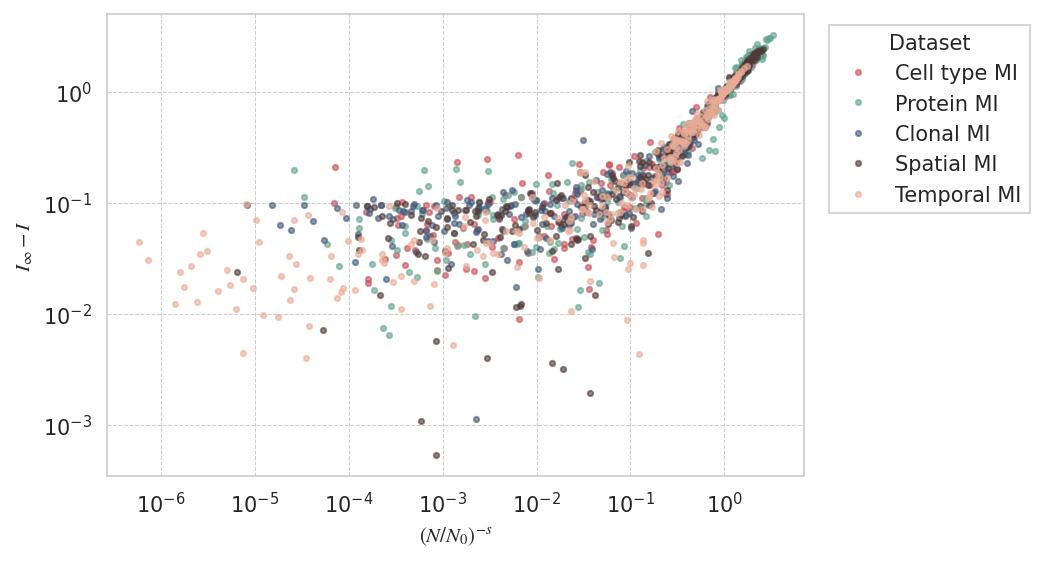

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))

# run the plotting functions
plot_precomputed(ax, df, sc_param_df, pretty_palette)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$(N/N_0)^{-s}$')
ax.set_ylabel(r'$I_{\infty} - I$')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left',
           bbox_to_anchor=(1.02, 1.), title='Dataset')

plotting pre-computed data... go!


Plotted 150 curves.


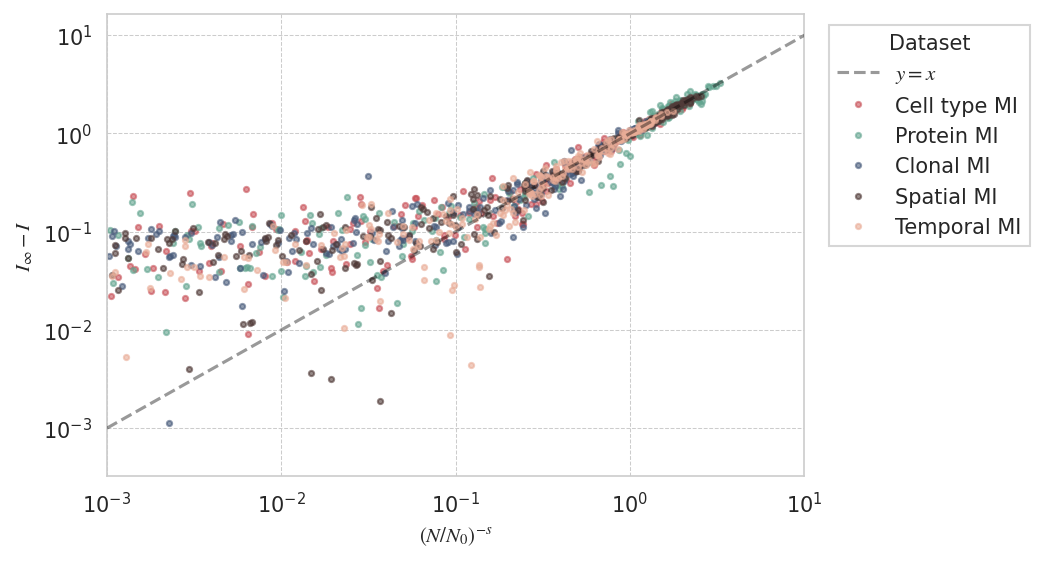

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))

xs = np.logspace(-3, 1, 100)
ax.plot(xs, xs, color='black', linestyle='--', alpha=0.4, lw=1.5,
         label=r'$y = x$',zorder=10)



# run the plotting functions
plot_precomputed(ax, df, sc_param_df, pretty_palette)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$(N/N_0)^{-s}$')
ax.set_ylabel(r'$I_{\infty} - I$')
ax.set_xlim(1e-3, 1e1)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left',
           bbox_to_anchor=(1.02, 1.), title='Dataset')

     dataset      method        metric  quality          N0      s  I_inf  \
0      larry         PCA     Clonal MI      1.0      22.783  1.039  1.554   
1       PBMC         PCA    Protein MI      1.0      42.109  1.038  3.945   
2    merfish         PCA    Spatial MI      1.0      37.525  1.015  1.643   
3   shendure         PCA   Temporal MI      1.0      30.905  1.007  1.175   
4       PBMC         PCA  Cell type MI      1.0      28.087  0.978  3.337   
5      larry  Geneformer     Clonal MI      1.0     121.260  0.582  1.105   
6   shendure  Geneformer   Temporal MI      1.0     165.343  0.402  2.003   
7    merfish  Geneformer    Spatial MI      1.0     107.360  0.332  1.409   
8      larry        SCVI     Clonal MI      1.0     273.803  0.314  2.009   
9    merfish        SCVI    Spatial MI      1.0     665.812  0.255  2.292   
10      PBMC        SCVI    Protein MI      1.0    7603.524  0.211  5.000   
11      PBMC  Geneformer  Cell type MI      1.0     264.892  0.165  3.507   

/tmp/ipykernel_2613326/1268275575.py:15: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_2613326/1268275575.py:32: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(


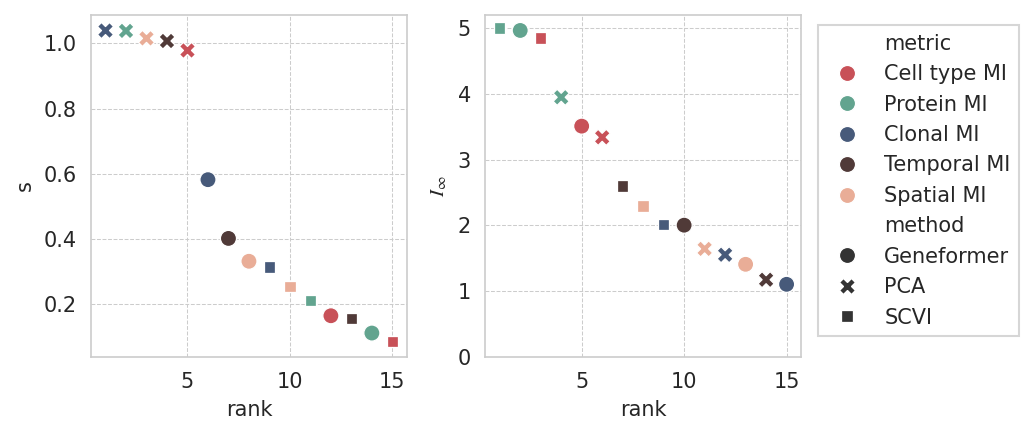

In [9]:
c6 = ['#c4bae2','#40ada6','#3c4ebf',
        '#e3a600', '#d6543a', '#edb1a3']
pretty_palette_2 = [c6[c] for c in range(6) if c in [1,2,3,4]]
hue_order = ['Rand. Proj.', 'PCA', 'SCVI', 'Geneformer']

# compute rank of s (highest to lowest)
subset = sc_param_df[sc_param_df['quality'] == 1]
subset = subset[subset['method'] != 'Rand. Proj.']
ranked = subset.sort_values('s', ascending=False).reset_index(drop=True)
ranked['rank'] = ranked.index + 1
print(ranked)

# plot
fig, axs = plt.subplots(1, 2, figsize=(7,3))
sns.scatterplot(
    data=ranked,
    x='rank', y='s',
    hue='metric',
    palette=pretty_palette,
    style='method',
    s=60,
    edgecolor='w',
    ax=axs[0],
    hue_order=['Cell type MI', 'Protein MI', 'Clonal MI', 'Temporal MI', 'Spatial MI'],
    style_order=['Geneformer', 'PCA', 'SCVI',],
    legend=False
)

ranked = subset.sort_values('I_inf', ascending=False).reset_index(drop=True)
ranked['rank'] = ranked.index + 1

sns.scatterplot(
    data=ranked,
    x='rank', y='I_inf',
    hue='metric',
    palette=pretty_palette,
    style='method',
    s=60,
    edgecolor='w',
    ax=axs[1],
    hue_order=['Cell type MI', 'Protein MI', 'Clonal MI', 'Temporal MI', 'Spatial MI'],
    style_order=['Geneformer', 'PCA', 'SCVI',],
)
plt.xlabel('rank')
axs[1].set_ylabel(r'$I_\infty$')
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left',)
plt.ylim(0, )
plt.tight_layout()
plt.show()

/tmp/ipykernel_2613326/2894462737.py:1: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  g = sns.scatterplot(


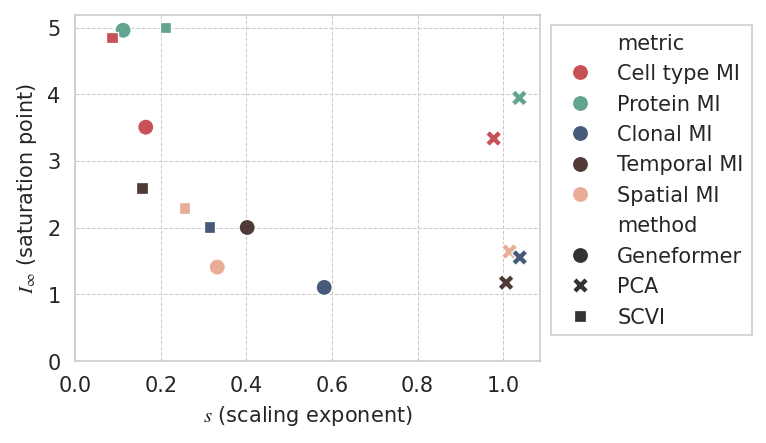

In [10]:
g = sns.scatterplot(
    data=ranked,
    x='s', y='I_inf',
    hue='metric',
    palette=pretty_palette,
    style='method',
    s=60,
    edgecolor='w',
    hue_order=['Cell type MI', 'Protein MI', 'Clonal MI', 'Temporal MI', 'Spatial MI'],
    style_order=['Geneformer', 'PCA', 'SCVI',],
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel(r'$s$ (scaling exponent)')
plt.ylabel(r'$I_\infty$ (saturation point)')
plt.xlim(0)
plt.ylim(0)
plt.show()

      dataset       method       metric  quality   N0      s  I_inf  \
189  shendure  Rand. Proj.  Temporal MI      1.0  0.0  1.051  0.622   

     mean_residual  
189            0.0  
      dataset method       metric  quality      N0      s  I_inf  \
179  shendure    PCA  Temporal MI      1.0  30.905  1.007  1.175   

     mean_residual  
179          0.052  
      dataset method       metric  quality       N0      s  I_inf  \
199  shendure   SCVI  Temporal MI      1.0  207.768  0.156  2.597   

     mean_residual  
199          0.059  
      dataset      method       metric  quality       N0      s  I_inf  \
169  shendure  Geneformer  Temporal MI      1.0  165.343  0.402  2.003   

     mean_residual  
169          0.054  


/tmp/ipykernel_2613326/351050818.py:27: RuntimeWarning: divide by zero encountered in divide
  ys = I_inf - (xs / N0) ** -s


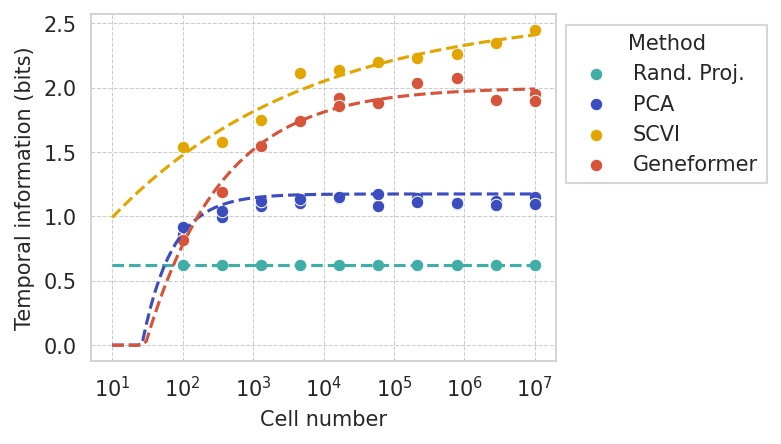

In [13]:
metric = 'Temporal MI'

for method in hue_order:
    subset = sc_param_df[(sc_param_df['quality'] == 1) &
                         (sc_param_df['method'] == method) &
                         (sc_param_df['metric'] == metric)]
    
    print(subset)
    
    s = subset['s'].values[0]
    N0 = subset['N0'].values[0]
    I_inf = subset['I_inf'].values[0]
    # I_0 = subset['I_0'].values[0]

    data = df[(df['quality'] == 1) &
              (df['algorithm'] == method) &
              (df['signal'] == metric)]
    
    sns.scatterplot(
        data=data,
        x='size',
        y=data['mi_value'].values,
        color=pretty_palette_2[hue_order.index(method)],
        label=method,
    )
    xs = np.logspace(1, 7, 100)
    ys = I_inf - (xs / N0) ** -s
    # max 0
    ys = np.maximum(ys, 0)
    # ys = np.maximum(ys, I_0)
    plt.plot(xs, ys, linestyle='--', color=pretty_palette_2[hue_order.index(method)])
plt.xscale('log')
plt.xlabel('Cell number')
plt.ylabel('Temporal information (bits)')
plt.legend(title='Method', bbox_to_anchor=(1, 1), loc='upper left')

   dataset      method      metric  quality          N0      s  I_inf  \
19    PBMC  Geneformer  Protein MI      1.0  999999.968  0.112  4.960   
39    PBMC         PCA  Protein MI      1.0      42.109  1.038  3.945   
79    PBMC        SCVI  Protein MI      1.0    7603.524  0.211  5.000   

    mean_residual    min I  I_inf - min I  
19          0.368  1.69727        3.26273  
39          0.097  3.57324        0.37176  
79          0.363  2.51507        2.48493  
    dataset      method     metric  quality       N0      s  I_inf  \
89    larry  Geneformer  Clonal MI      1.0  121.260  0.582  1.105   
99    larry         PCA  Clonal MI      1.0   22.783  1.039  1.554   
119   larry        SCVI  Clonal MI      1.0  273.803  0.314  2.009   

     mean_residual    min I  I_inf - min I  
89           0.169  0.03407        1.07093  
99           0.072  1.31845        0.23555  
119          0.126  0.69558        1.31342  
     dataset      method      metric  quality       N0      s  I_inf  

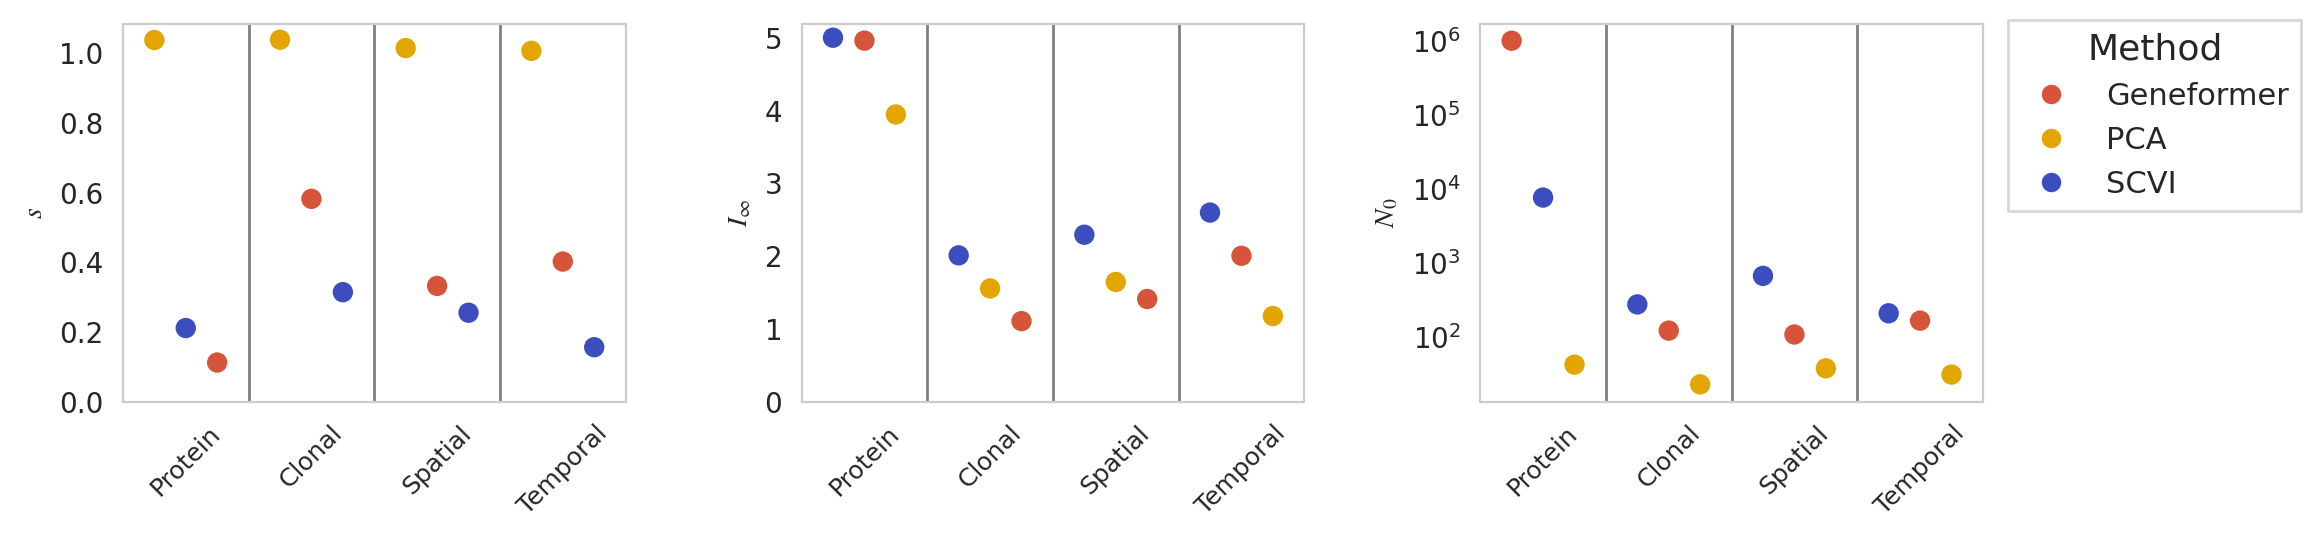

In [29]:
c6 = ['#c4bae2','#40ada6','#3c4ebf',
        '#e3a600', '#d6543a', '#edb1a3']
pretty_palette = [c6[c] for c in range(6) if c in [1,2,3,4]]

rcParams['grid.linewidth'] = 0.5
rcParams['grid.alpha'] = 0

color_dict = {
    "Geneformer": pretty_palette[3],
    "PCA": pretty_palette[2],
    "SCVI": pretty_palette[1],
}

# fixed method ordering for groups (replace / extend as needed)
method_order = ["Geneformer", "PCA", "SCVI"]

# build 3 horizontal panels: s, I_inf, N0
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharex=True, dpi=200)
axs = axs.ravel()

x_count = 0
all_labels = []

# for centered metric xticks
center_positions = []
metric_labels = []

# iterate metrics, keep same ordering (method_order) within each group
for metric in sc_param_df['metric'].unique():
    if metric == 'Cell type MI':
        continue
    subset = sc_param_df[(sc_param_df['quality'] == 1) &
                         (sc_param_df['metric'] == metric)].copy()
    
    subset['I_inf - min I'] = subset['I_inf'] - subset['min I']

    subset = subset[subset['I_inf - min I'] > 0.2]

    subset = subset[subset['mean_residual'] < 0.5]
    
    cell_number_min = df[(df['signal'] == metric)]['size'].min()
    subset = subset[subset['method'] != 'Rand. Proj.']
    print(subset)

    # subset['N_90'] = [x if subset['I_0'].values[i]/subset['I_inf'].values[i] < 0.9 else cell_number_min
    #                 for i, x in enumerate(subset['N_90'].values)]
    
    # subset['N0_truncated'] =  [x if subset['I_0'].values[i] - subset['I_inf'].values[i] < -1 else cell_number_min
    #                 for i, x in enumerate(subset['N0'].values)]
    
    if subset.empty:
        continue

    n = len(subset)
    positions = x_count + np.arange(n)

    # compute center of this group's span for placing metric xtick
    group_center = x_count + (n - 1) / 2.0
    center_positions.append(group_center)
    metric_labels.append(metric)

    # scatter in each panel
    subset = subset.sort_values(by='s', ascending=False)
    axs[0].scatter(positions, subset['s'],
                   color=[color_dict.get(m, 'black') for m in subset['method']],
                   zorder=3, s=40)
    subset = subset.sort_values(by='I_inf', ascending=False)
    axs[1].scatter(positions, subset['I_inf'],
                   color=[color_dict.get(m, 'black') for m in subset['method']],
                   zorder=3, s=40)
    subset = subset.sort_values(by='N0', ascending=False)
    axs[2].scatter(positions, subset['N0'],
                   color=[color_dict.get(m, 'black') for m in subset['method']],
                   zorder=3, s=40)

    # vertical separator after group
    sep_x = x_count + n
    for ax in axs:
        ax.axvline(x=sep_x, color='black', linestyle='-', alpha=0.5, lw=1)

    # collect labels for xticks (one per point) if you still need them
    all_labels.extend(list(subset['method'] + ' - ' + subset['metric']))

    x_count += n + 1

# place metric names centered above each group on the middle panel
if len(center_positions) > 0:
    for i in range(3):
        axs[i].set_xticks(center_positions)
        axs[i].set_xticklabels([m[:-3] for m in metric_labels], rotation=45, ha='center', fontsize=9)
        axs[i].set_xlim(-1, x_count - 1)
        # axs[i].grid(axis='y')

# y-axis labels and scales
axs[0].set_ylabel(r'$s$')
axs[0].set_ylim(0,)


axs[1].set_ylabel(r'$I_{\infty}$')
axs[1].set_ylim(0, )

axs[2].set_ylabel(r'$N_{0}$')
axs[2].set_yscale('log')

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=m,
                                  markersize=8, markerfacecolor=color_dict[m])
                   for m in method_order if m in color_dict],
               title='Method', title_fontsize='13', fontsize='11',
               bbox_to_anchor=(1.02, 1.05), loc='upper left', fancybox=False)

# tighten layout and show
plt.subplots_adjust(wspace=0.35, bottom=0.25)
# plt.grid('off')
plt.show()


In [25]:
df[(df['quality'] == 1) & (df['algorithm'] == 'SCVI') & (df['signal'] == 'Cell type MI')]

,dataset,size,quality,algorithm,signal,seed,mi_value,umis_per_cell
187,PBMC,100,1.0,SCVI,Cell type MI,42,2.80230,8100
188,PBMC,100,1.0,SCVI,Cell type MI,2303,2.73062,8100
189,PBMC,100,1.0,SCVI,Cell type MI,2701,2.83461,8100
388,PBMC,215,1.0,SCVI,Cell type MI,42,2.80423,8100
389,PBMC,215,1.0,SCVI,Cell type MI,2303,2.76082,8100
390,PBMC,215,1.0,SCVI,Cell type MI,2701,2.77874,8100
592,PBMC,464,1.0,SCVI,Cell type MI,42,2.81555,8100
593,PBMC,464,1.0,SCVI,Cell type MI,2303,2.78000,8100
594,PBMC,464,1.0,SCVI,Cell type MI,2701,2.79663,8100
783,PBMC,1000,1.0,SCVI,Cell type MI,42,2.92303,8100
